In [1]:
import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Road Sign Dataset
The dataset is small, containing only 877 images in total. While we may want to train with a larger dataset to fully realize YOLO's capabilities, we use a small dataset in this tutorial to facilitate quick prototyping.

In [2]:
import kagglehub
path = kagglehub.dataset_download("ndrewmvd/road-sign-detection")
print(f"Path to dataset file: {path}")

/home/sebdui/pcbYOLO/.yoloPcb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KaggleApiHTTPError: 403 Client Error.

You don't have permission to access resource at URL: https://api.kaggle.com/v1/datasets.DatasetApiService/GetDataset. Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.

In [7]:
%mv /home/sebdui/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1 /home/sebdui/pcbYOLO/Road_Sign_Dataset/

mv: cannot stat '/home/sebdui/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1': No such file or directory


## Convert the Annotations into the YOLO v5 Format
There are a variety of formats when it comes to annotations for object detection datasets. Annotations for the datset we downloaded follow the PASCAL VOC XML format, which is a very popular format.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home/sebdui/pcbYOLO


In [4]:
%cd {HOME}/Road_Sign_Dataset/RoadSignDetectionDataset

/home/sebdui/pcbYOLO/Road_Sign_Dataset/RoadSignDetectionDataset


In [6]:
!cat annotations/road4.xml


<annotation>
    <folder>images</folder>
    <filename>road4.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>20</xmin>
            <ymin>109</ymin>
            <xmax>81</xmax>
            <ymax>237</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>162</ymin>
            <xmax>163</xmax>
            <ymax>272</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

The above annotation file describes a file named `road4.jpg` with dimensions 267 x 400 x 3. It has 3 object tags, which represent 3 bounding boxes. The class is specified by the name tag, whereas the details of the bounding box are represented by the bnbox tag. A bounding box is described by its top-left (x_min, y_min) corner coordinates and its bottom-right (xmax, ymax) corner.<br>

We now write a function that will take the annotations in VOC format and convert them to a format in which information about the bounding boxes is stored in a dictionary. 

In [71]:
# Function to get the data from XML Annotation
import xml.etree.ElementTree as ET

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initiallize the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bouding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)
    return info_dict

In [72]:
info_dictionary = extract_info_from_xml('annotations/road4.xml')
b = info_dictionary["bboxes"]
print(b[1]["class"])
print(info_dictionary["filename"])

trafficlight
road4.png


We now write a function to convert information contained in `info_dict` to YOLO v5 style annotations and write them to a txt file.

In [73]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [74]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:]=="xml"]
annotations.sort()
print(len(annotations))

877


In [75]:
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 23047.50it/s]


## Testing the Annotations

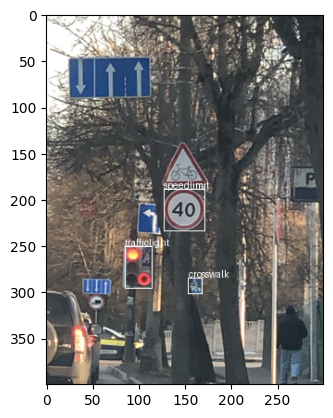

In [29]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## Partition the Dataset
Next we partition the dataset into train, validation, and test sets containing 80%, 10%, and 10% of the data, respectively. You can change the split values according to your convenience.

In [56]:
# Read images and annotations
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
images = [os.path.join('images', x) for x in os.listdir('images') if x.lower().endswith(image_extensions)]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
print(type(images))
print(f"First image before sorting: {images[1]}")
print(f"First annotation before sorting: {annotations[1]}")

<class 'list'>
First image before sorting: images/road243.png
First annotation before sorting: annotations/road731.txt


In [57]:
images.sort()
annotations.sort()

print(f"First image after sorting: {images[0]}")
print(f"First annotation after sorting: {annotations[0]}")

First image after sorting: images/road0.png
First annotation after sorting: annotations/road0.txt


In [58]:
# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations  = train_test_split(val_images, val_annotations, test_size = 0.5, random_state= 1)

In [64]:
print(f"Size of train images: {len(train_images)}")
print(f'Size of test images: {len(test_images)}')

Size of train images: 701
Size of test images: 88


In [65]:
print(f"Size of train annotationss: {len(train_annotations)}")
print(f"Size of test annottionsL {len(test_annotations)}")

Size of train annotationss: 701
Size of test annottionsL 88


In [66]:
print(f"Size of validation images: {len(val_images)}")

Size of validation images: 88


In [77]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

mkdir: cannot create directory ‘images/train’: File exists
mkdir: cannot create directory ‘images/val’: File exists
mkdir: cannot create directory ‘images/test’: File exists


In [68]:
# Utility function to move images
import shutil
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')

In [78]:
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [79]:
%mv annotations labels
%cd ../RoadSignDetectionDataset/Road_Sign_Dataset

[Errno 2] No such file or directory: '../RoadSignDetectionDataset/Road_Sign_Dataset'
/home/sebdui/pcbYOLO/Road_Sign_Dataset/RoadSignDetectionDataset


In [80]:
%ls

images/  labels/


In [82]:
os.getcwd()

'/home/sebdui/pcbYOLO/Road_Sign_Dataset/RoadSignDetectionDataset'

In [83]:
%cd ../..

/home/sebdui/pcbYOLO


## Training Options
While we train the network, we use various flags to set options regarding training.
* **img** : Size of image. The image is a square one. The original image is resized while maintaining the aspect ratio. The longer side of the image is resized to this nunber. The shorter side is padded with with gray.
* **batch** : The batch size
* **data** : Data YAML file that contains information about the dataset (path of images, labels)
* **workers** : Number of CPU workers
* **cfg** : Model architecture. There are 4 choices available: `yolo5s.yaml`, `yolo5m.yaml`, `yolo5l.yaml`, `yolo5x.yaml`. The size and complexity of these models increase in the ascending order and you can choose a model which suits the complexity of your object detection task. In case you want to work with a custom architecture, you will have to define a `YAML` file in the `models`folder specifying the network architecture.
* **weights** : Pretrained weights you want to start training from. If you want to train from scratch, use `--weights ' '`
* **name** : Various things about training such as train logs. Training weights would be stored in a folder named `runs/train/name`
* **hyp** : YAML file that describes hyperparameter choices. For examples of how to define hyperparameters, see `data/hyp.scratch.yaml`. If unspecified, the file `data/hyp.scratch.yaml` is used.

### Data Config File
Details for the dataset you want to train your model on are defined by the data config `YAML` file. The following parameters have to be defined in a data config file:

1. `train`, `test`, and `val` : Locations of train, test, and validation images.
2. `nc` : Number of classes in the dataset.
3. `names` : Names of classes in the dataset. The index of the classes in this list would be used as an identifier for the class names in the code.

Create a new file called `road_sign_data.yaml` and place it in the `pcbYOLO/data` folder.

### Hyperparameter Config File
The hyperparameter config file helps us define the hyperparameters for our neural network. We are going to use the default one, `data/hyp.scratch.yaml`.

### Custom Network Architecture
YOLO v5 also allows you to define your own custom architecture and anchors if one of the pre-defined networks doesn't fit the bill for you. For this you will have to define a custom weights config file. For this example, we use the `yolov5s.yaml`.

### Train the Model
We define the location of `train`, `val` and `test`, the number of classes (`nc`) and the names of the classes. Since the dataset is small, and we don't have many objects per image, we start with the smallest of pretrained models `yolo5s` to keep things simple and avoid overfitting. We keep a batch size of `32`, image size of `640`, and train for 100 epochs. If you have issues fitting the model into memory:
* Use a smaller batch size
* Use a smaller network
* Use a smaller image size

Of course, all of the above might impact the performance. The compromise is a design decision you have to make. You might want to go for a bigger GPU instance as well, depending on the situation.

We use the name `yolo_road_det` for our training. The tensorboard training loss can be found at `runs/train/yolo_read_det`.

In [95]:
%cd ../yolov5/
!/home/sebdui/pcbYOLO/.yoloPcb/bin/python train.py \
--img 640 \
--cfg yolov5s.yaml \
--hyp hyp.scratch.yaml \
--batch 32 \
--epochs 100 \
--data road_sign_data.yaml \
--weights yolov5s.pt \
--workers 24 \
--name yolo_road_det

/home/sebdui/yolov5
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=road_sign_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: ⚠️ YOLOv5 is out of date by 3 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24079MiB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, wei

In [91]:
!which python

/home/sebdui/soundClassification/.soundClassification/bin/python


## Inference


There are many ways to run inference using the `detect.py` file. 

The `source` flag defines the source of our detector, which can be:
1. A single image
2. A folder of images
3. Video
4. * Webcam

..and various other formats. We want it to run over our test images so we set the `source` flag to `.../Road_Sign_Dataset/images/test/`.

* The `weights` flag defines the path of the model which we want to run our detector with.
* `conf` flag is the thresholding objectness confidence.
* `name` flag defines where the detections are stored. We set this flag to `yolo_road_set`; therefore, the detections would be stored in `runs/detect/yolo_road_det/`/

In [96]:
print(os.getcwd())

/home/sebdui/yolov5


In [97]:
!/home/sebdui/pcbYOLO/.yoloPcb/bin/python detect.py \
--source ../yolov5/data/Road_Sign_Dataset/images/test/ \
--weights runs/train/yolo_road_det6/weights/best.pt \
--conf 0.25 \
--name yolo_road_det6

detect: weights=['runs/train/yolo_road_det6/weights/best.pt'], source=../yolov5/data/Road_Sign_Dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_road_det6, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24079MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/88 /home/sebdui/yolov5/data/Road_Sign_Dataset/images/test/road100.png: 640x640 1 speedlimit, 1.3ms
image 2/88 /home/sebdui/yolov5/data/Road_Sign_Dataset/images/test/road113.png: 448x640 1 speedlimit, 13.9ms
image 3/88 /home/sebdui/yolov5/data

WE can now randomly plot one of the detections.

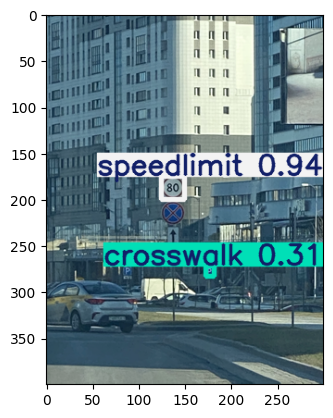

In [101]:
detections_dir = "runs/detect/yolo_road_det6/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## Computing the mAP on the test dataset

We can use the `test`file to compute the mAP on our test set. To perform the evalauation on our test set, we set the `task` flag to `test`. We set the name to `yolo_det`. Things like plots of various curves (F1, AP, Precision curves etc) can be found in the folder `runs/test/yolo_road_det`. The script calculates for us the Average precision for each class as well as mean Average Precision. 

In [103]:
!/home/sebdui/pcbYOLO/.yoloPcb/bin/python val.py \
--weights runs/train/yolo_road_det6/weights/best.pt \
--data road_sign_data.yaml \
--task test \
--name yolo_det6

val: data=/home/sebdui/yolov5/data/road_sign_data.yaml, weights=['runs/train/yolo_road_det6/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det6, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24079MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /home/sebdui/yolov5/data/Road_Sign_Dataset/labels/test... 88 imag
test: New cache created: /home/sebdui/yolov5/data/Road_Sign_Dataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   
                   all         88        126      0.948      0.932      0.935      0.781
          trafficlight         88         20      0.913        0